In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

### Parameters
#### Beam parameters

In [23]:
wl = 1030.0 # (nm)

harmonic0 = 1
pulse_duration0 = 0.18  # (ps)
energy0 = 4e-6  # (J)
waist0 = 11e-6  # (m)

harmonic1 = 1
pulse_duration1 = 0.18  # (ps)
energy1 = 4e-6  # (J)
waist1 = 11e-6  # (m)

harmonic2 = 4
pulse_duration2 = 0.18  # (ps)
energy2 = 0.5e-6  # (J)
waist2 = 11e-6  # (m)

rep_rate = 1  # (MHz)

#### Fiber parameters

In [24]:
beta2 = -1.2  # (ps^2/km)
beta3 = 0.00  # (ps^3/km)
beta4 = 0.005  # (ps^4/km)
pressure_in_atm = 2.858

fiber_length = 50  # length in mm

alpha = 5e-4  # attentuation coefficient (dB/cm)
# gamma = 9.629e-4 * pressure_in_atm # Gamma (1/(W km))'
gamma = 0.01

fib_wl = 1064  # Center WL of fiber (nm)

raman = True  # Enable Raman effect?
steep = True  # Enable self steepening?

alpha = np.log((10 ** (alpha * 0.1))) * 100  # convert from dB/cm to 1/m

#### Simulation parameters

In [25]:
window = 0.5  # simulation window (ps)
steps = 100  # simulation steps
points = 2**13  # simulation points

### Simulation

#### Create pulses

Three pulses

c:\Users\Jeremy\miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Photon energy (eV)')

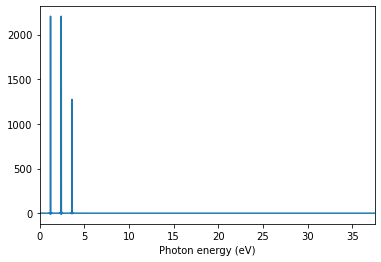

In [5]:
pulse0 = pynlo.light.DerivedPulses.SechPulse(
    power=1,
    T0_ps=pulse_duration0 / 1.76,
    center_wavelength_nm=wl/harmonic0,
    time_window_ps=window,
    GDD=0.0,
    TOD=0.0,
    NPTS=points,
    frep_MHz=rep_rate,
    power_is_avg=False,
)
pulse0.set_epp(energy0)

# Generate 515 nm pulse
pulse1 = pynlo.light.DerivedPulses.SechPulse(
    power=1,
    T0_ps=pulse_duration1 / 1.76,
    center_wavelength_nm=wl/harmonic1,
    time_window_ps=window,
    GDD=0.0,
    TOD=0.0,
    NPTS=points,
    frep_MHz=rep_rate,
    power_is_avg=False,
)
pulse1.set_epp(energy1)

# Generate 343 nm pulse
pulse2 = pynlo.light.DerivedPulses.SechPulse(
    power=1,
    T0_ps=pulse_duration2 / 1.76,
    center_wavelength_nm=wl/harmonic2,
    time_window_ps=window,
    GDD=0.0,
    TOD=0.0,
    NPTS=points,
    frep_MHz=rep_rate,
    power_is_avg=False,
)
pulse2.set_epp(energy2)

# Add two pulses together
diff = pulse1._centerfrequency - pulse0._centerfrequency
shift = np.floor(diff / pulse1.dF_THz).astype(int)

spectrum_2w = np.roll(pulse1._get_AW(), -shift)
spectrum_3w = pulse1._get_AW()
pulse1.set_AW(spectrum_2w + spectrum_3w)

# Add third pulse
diff = pulse2._centerfrequency - pulse1._centerfrequency
shift = np.floor(diff / pulse2.dF_THz).astype(int)

spectrum_2w = np.roll(pulse1._get_AW(), -shift)
spectrum_3w = pulse2._get_AW()
pulse2.set_AW(spectrum_2w + spectrum_3w)


plt.plot(pulse2.F_THz* 0.004136, pulse2.AW)
plt.xlim(0, np.max(pulse2.F_THz* 0.004136))
plt.xlabel("Photon energy (eV)")

Two pulses

c:\Users\Jeremy\miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Photon energy (eV)')

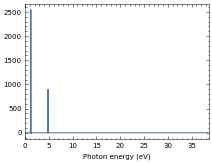

In [26]:
# Generate 515 nm pulse
pulse1 = pynlo.light.DerivedPulses.SechPulse(
    power=1,
    T0_ps=pulse_duration1 / 1.76,
    center_wavelength_nm=wl/harmonic1,
    time_window_ps=window,
    GDD=0.0,
    TOD=0.0,
    NPTS=points,
    frep_MHz=rep_rate,
    power_is_avg=False,
)
pulse1.set_epp(energy1)

# Generate 343 nm pulse
pulse2 = pynlo.light.DerivedPulses.SechPulse(
    power=1,
    T0_ps=pulse_duration2 / 1.76,
    center_wavelength_nm=wl/harmonic2,
    time_window_ps=window,
    GDD=0.0,
    TOD=0.0,
    NPTS=points,
    frep_MHz=rep_rate,
    power_is_avg=False,
)
pulse2.set_epp(energy2)

# Add two pulses together
diff = pulse2._centerfrequency - pulse1._centerfrequency
shift = np.floor(diff / pulse2.dF_THz).astype(int)

spectrum_2w = np.roll(pulse1._get_AW(), -shift)
spectrum_3w = pulse2._get_AW()
pulse2.set_AW(spectrum_2w + spectrum_3w)

plt.plot(pulse2.F_THz* 0.004136, pulse2.AW)
plt.xlim(0, np.max(pulse2.F_THz* 0.004136))
plt.xlabel("Photon energy (eV)")

#### Create fiber

In [27]:
fiber = pynlo.media.fibers.fiber.FiberInstance()
fiber.generate_fiber(
    fiber_length * 1e-3,
    center_wl_nm=fib_wl,
    betas=(beta2, beta3, beta4),
    gamma_W_m=gamma * 1e-3,
    gvd_units="ps^n/km",
    gain=-alpha,
)

#### Propagate

In [28]:
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(
    local_error=0.005,
    USE_SIMPLE_RAMAN=True,
    disable_Raman=np.logical_not(raman),
    disable_self_steepening=np.logical_not(steep),
)

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse2, fiber=fiber, n_steps=steps)

### Plotting

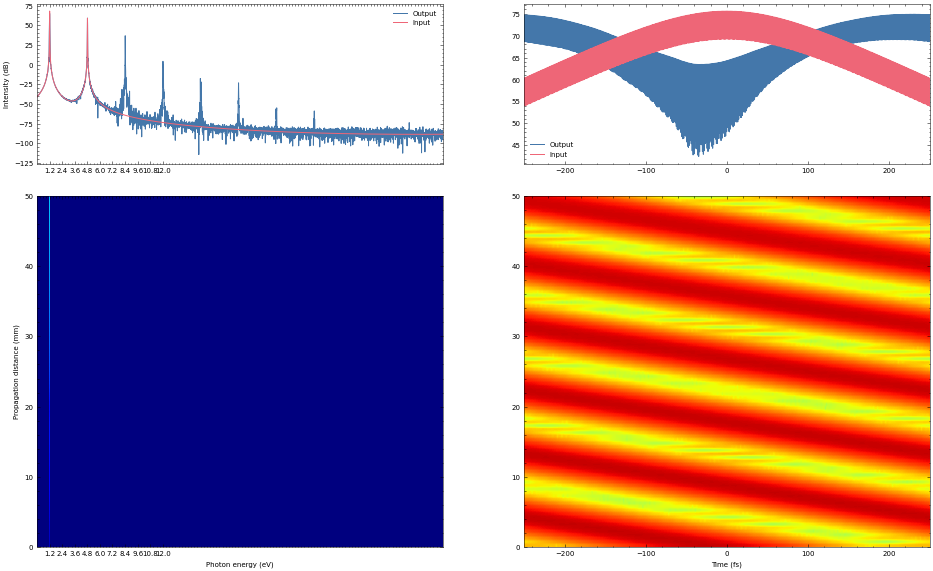

In [29]:
h = 4.136e-3  # Planck's constant (eV/THz)

# Set up plots for the results:
fig = plt.figure(figsize=(16, 10))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)

F = h * pulse2.F_THz  # Frequency grid of pulse (THz)


def dB(num):
    return 10 * np.log10(np.abs(num) ** 2)


zW = dB(np.transpose(AW)[:, (F > 0)])
zT = dB(np.transpose(AT))

y_mm = y * 1e3  # convert distance to mm

ax0.plot(h * pulse_out.F_THz, dB(pulse_out.AW), label="Output")
ax1.plot(pulse_out.T_ps*1000, dB(pulse_out.AT), label="Output")

ax0.plot(h * pulse2.F_THz, dB(pulse2.AW), label="Input")
ax1.plot(pulse2.T_ps*1000, dB(pulse2.AT), label="Input")

extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, fiber_length)
ax2.imshow(
    zW,
    extent=extent,
    vmin=np.max(zW) - 40.0,
    vmax=np.max(zW),
    aspect="auto",
    origin="lower",
    cmap="jet",
)

extent = (np.min(pulse2.T_ps)*1000, np.max(pulse2.T_ps)*1000, np.min(y_mm), fiber_length)
ax3.imshow(
    zT,
    extent=extent,
    vmin=np.max(zT) - 40.0,
    vmax=np.max(zT),
    aspect="auto",
    origin="lower",
    cmap="jet",
)

ax0.set_ylabel("Intensity (dB)")
# ax0.set_ylim(-80, 0)
# ax1.set_ylim(-40, 40)

ax2.set_ylabel("Propagation distance (mm)")
ax2.set_xlabel("Photon energy (eV)")

ax3.set_xlabel("Time (fs)")

ax0.set_xticks([1.2, 2.4, 3.6, 4.8, 6.0, 7.2, 8.4, 9.6, 10.8, 12.0])
ax0.set_xticklabels(["1.2", "2.4", "3.6", "4.8", "6.0", "7.2", "8.4", "9.6", "10.8", "12.0"])
ax0.legend()

ax2.set_xticks([1.2, 2.4, 3.6, 4.8, 6.0, 7.2, 8.4, 9.6, 10.8, 12.0])
ax2.set_xticklabels(["1.2", "2.4", "3.6", "4.8", "6.0", "7.2", "8.4", "9.6", "10.8", "12.0"])


ax1.legend()

plt.show()

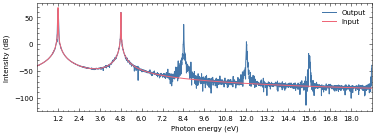

In [30]:
plt.style.use(["science", "nature", "bright", "no-latex"])

plt.figure(figsize=(6, 2))

plt.plot(h * pulse_out.F_THz, dB(pulse_out.AW), label="Output")
plt.plot(h * pulse2.F_THz, dB(pulse2.AW), label="Input")

plt.xlim(0, 19.2)
plt.xticks([1.2, 2.4, 3.6, 4.8, 6.0, 7.2, 8.4, 9.6, 10.8, 12.0, 13.2, 14.4, 15.6, 16.8, 18.0], ["1.2", "2.4", "3.6", "4.8", "6.0", "7.2", "8.4", "9.6", "10.8", "12.0", "13.2", "14.4", "15.6", "16.8", "18.0"])
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (dB)")
plt.legend()

plt.savefig("figure.png", dpi=300)

plt.show()

In [27]:
# save data

np.save("w2w3w_input_f.npy", h*pulse2.F_THz)
np.save("w2w3w_output_f.npy", h*pulse_out.F_THz)
np.save("w2w3w_input_AW.npy", dB(pulse2.AW))
np.save("w2w3w_output_AW.npy", dB(pulse_out.AW))